# Setup

## Imports

In [1]:
using Pkg
Pkg.activate("SCC", shared=true)


import QuantumToolbox as qt
using Logging
import CairoMakie as cm
using MiniLoggers
using Revise
using Dates

using RecursiveArrayTools
using Tensors
using ProgressLogging

using DimensionalData


using DifferentialEquations

import LsqFit

import JSON3
import CSV

using IJulia
if isdefined(Main, :IJulia)
    Main.IJulia.stdio_bytes[] = 0;
end

  Activating project at `~/.julia/environments/SCC`


0

In [2]:
import SuperconductingCavities as SC

[ Info: new driver key :netcdf, updating backendlist.


## Logger Setup

In [3]:
# MiniLogger(minlevel = MiniLoggers.Info) |> global_logger
InfoLogger = MiniLogger(minlevel = MiniLoggers.Info)
ProgressLogger = MiniLogger(minlevel = LogLevel(-1))
DebugLogger = MiniLogger(minlevel = MiniLoggers.Debug)

global_logger(ProgressLogger)

ConsoleLogger(IJulia.IJuliaStdio{Base.PipeEndpoint}(IOContext(Base.PipeEndpoint(RawFD(40) open, 0 bytes waiting))), Info, Base.CoreLogging.default_metafmt, true, 0, Dict{Any, Int64}())

# Making Model

In [4]:
Mode3 = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode3/Mode3.json");

# Testing a Wigner Plot

In [5]:
ψ = Mode3.dressed_states[(0,0)];

In [6]:
xvec = range(-5,5,200)
yvec = range(-5,5,200)

ρr = qt.ptrace(ψ,2)

wig = qt.wigner(ρr, xvec, yvec);

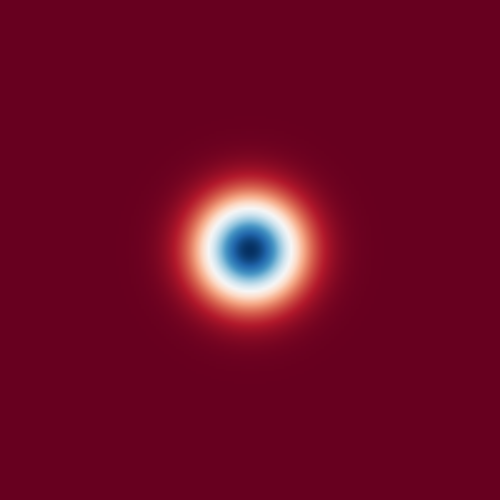

In [7]:
fig = cm.Figure(size = (250, 250), figure_padding = 0)
ax = cm.Axis(fig[1, 1])
cm.heatmap!(ax, xvec, yvec, wig', colormap = :RdBu, interpolate = true, rasterize = 1)
cm.hidespines!(ax)
cm.hidexdecorations!(ax)
cm.hideydecorations!(ax)
fig

# Driving the Cavity

In [8]:
Mode3.params

Dict{Any, Any} with 17 entries:
  "d_t"          => 0
  "Nrs"          => Any[10]
  "E_C"          => 0.102833
  "Cavity_Names" => Any["Mode3"]
  "E_J"          => 26.9698
  "Nt_cut"       => 60
  "E_oscs"       => Any[6.22808]
  "Nt"           => 10
  "ModelType"    => "TransmonResonators"
  "ng"           => 0
  "kappa_tc"     => 1.78571e-5
  "kappa_td"     => 1.2348e-5
  "d_r"          => Any[1]
  "kappa_cc"     => Any[1.0e-6]
  "Model_Name"   => "Mode3"
  "gs"           => Any[0.0268772]
  "Save_Path"    => "ModelSaves/Mode3/"

In [9]:
op_params = Dict{Any, Any}()
op_params["pulse_time"] = 100
op_params["freq_d"] = Mode3.params["E_oscs"][1]
op_params["shift"] = 0
op_params["epsilon"] = 0.1im
op_params["Envelope"] = "Sine_Squared_Ramp"
op_params["Envelope Args"] = Dict{Any, Any}("pulse_time" =>op_params["pulse_time"], "ramp_time" => 4)


ψ0 = Mode3.dressed_states[(0,0)];

run_dat = SC.Dynamics.RunSingleOperator(Mode3, ψ0, op_params)

[2024-12-15 15:19:46] Info: Running Time Evolution
Progress: [==============================] 100.0% --- Elapsed Time: 0h 00m 05s (ETA: 0h 00m 00s)
[2024-12-15 15:19:53] Info: Time Evolution Complete
[2024-12-15 15:19:53] Info: Done with DEFAULT


Solution of time evolution
(return code: Success)
--------------------------
num_states = 501
num_expect = 0
ODE alg.: OrdinaryDiffEqVerner.Vern9{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}(OrdinaryDiffEqCore.trivial_limiter!, OrdinaryDiffEqCore.trivial_limiter!, static(false), true)
abstol = 1.0e-6
reltol = 1.0e-6


In [10]:
ψ0'*run_dat.states[end]

0.06554329573840456 - 0.109400200018391im

In [11]:
ψ = run_dat.states[end]

xvec = range(-5,5,200)
yvec = range(-5,5,200)

ρr = qt.ptrace(ψ,2)

wig = qt.wigner(ρr, xvec, yvec);

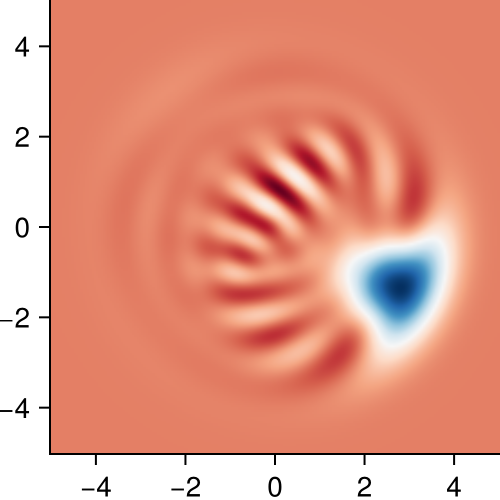

In [12]:
fig = cm.Figure(size = (250, 250), figure_padding = 0)
ax = cm.Axis(fig[1, 1])
cm.heatmap!(ax, xvec, yvec, wig', colormap = :RdBu, interpolate = true, rasterize = 1)
#cm.hidespines!(ax)
#cm.hidexdecorations!(ax)
#cm.hideydecorations!(ax)
fig

# Large Mode 3

In [4]:
Mode3Large = SC.Circuits.Transmon_Resonators.load("ModelSaves/Mode3Large/Mode3Large.json");

In [34]:
ε = 0.1
νs = collect(LinRange(-0.3e-3, 0.3e-3, 100))

params = [Dict{Any, Any}("ε"=>ε, "ν" => ν+Mode3Large.params["E_oscs"][1]) for ν in νs];



In [35]:
floq_sweep = SC.Dynamics.Floquet_t0_Sweep(Mode3Large, params, states_to_track=Mode3Large.dressed_states);

[2024-12-17 17:56:08] Info: Beginning Floquet Sweep


Progress: 100%|█████████████████████████████████████████| Time: 0:05:45


[2024-12-17 18:01:54] Info: Done With Floquet Sweep
[2024-12-17 18:01:54] Info: Tracking State


Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


[2024-12-17 18:01:55] Info: Running the necessary time evolutions


In [36]:
floq_sweep[State = At(string((0,0)))][1]["Quasienergies"]

1.7207845801431143

In [37]:
χ_e(model) = (model.dressed_energies[(1,1)]-model.dressed_energies[(0,1)])-(model.dressed_energies[(1,0)]-model.dressed_energies[(0,0)]);
χ_e(Mode3Large)*1000

-0.2058384300767102

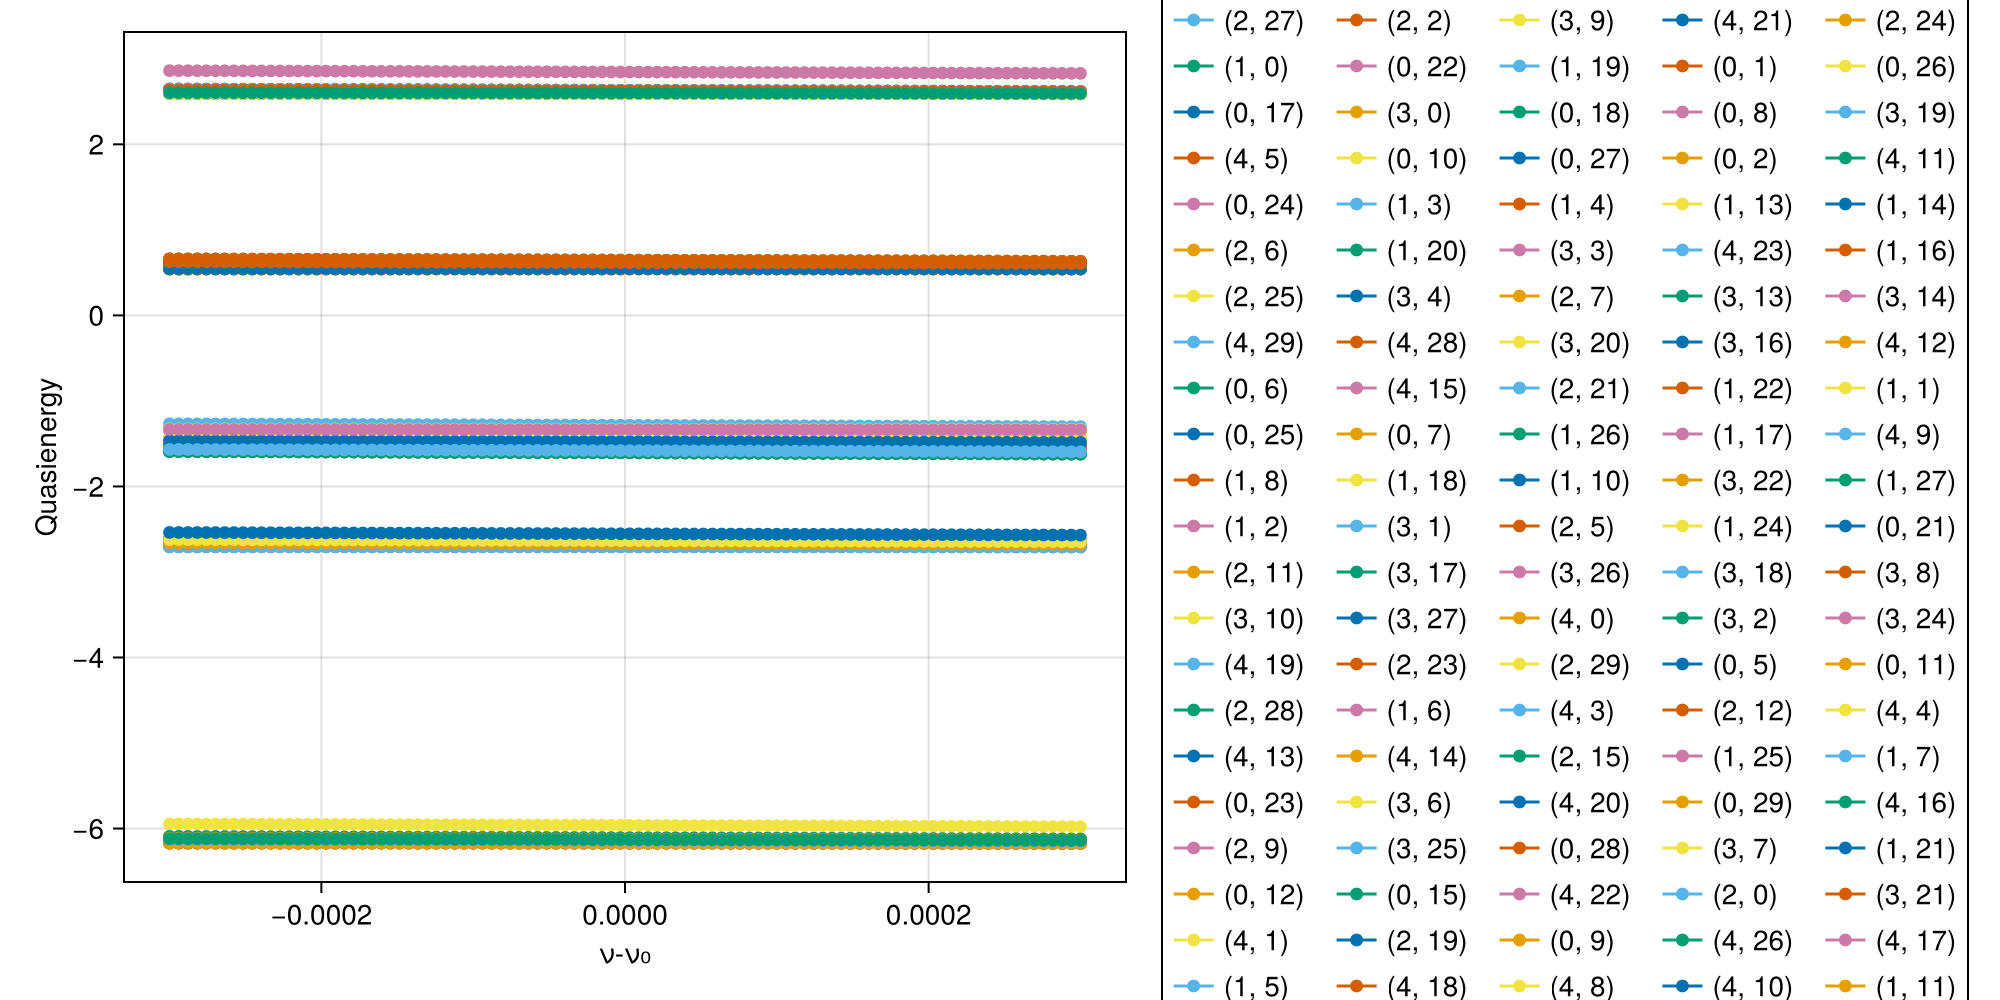

CairoMakie.Screen{IMAGE}


In [38]:
fig = cm.Figure(size = (1000, 500))
ax = cm.Axis(fig[1, 1], xlabel = "ν-ν₀", ylabel = "Quasienergy")
for state in keys(Mode3Large.dressed_energies)
    y_dat = [floq_sweep[State = At(string(state))][i]["Quasienergies"][1] for i in 1:length(νs)]/(π)

    cm.scatterlines!(ax, νs, y_dat, label = string(state))
end

cm.Legend(fig[1,2], ax, position = :rt, nbanks = 5)

display(fig)

In [32]:
println(floq_sweep[State = At(string((0,0)))][50]["Quasienergies"]/pi)
println(floq_sweep[State = At(string((3,0)))][50]["Quasienergies"]/pi)

println(floq_sweep[State = At(string((3,0)))][50]["Quasienergies"]/pi-floq_sweep[State = At(string((0,0)))][50]["Quasienergies"]/pi)

0.5385911001820146
2.5930422123577044
2.05445111217569


# random 

In [19]:
H = Mode3Large.Ĥ
νft = Mode3Large.params["E_oscs"][1]
ε0 = 0.1
T = abs(1/νft)
drive_coef = SC.Dynamics.Get_Drive_Coef(νft, ε0)
Ĥ_D = SC.Dynamics.Get_Ĥ_D(Mode3Large.Ô_drive , drive_coef)

floq_sys = SC.Dynamics.Get_Floquet_t0_Eigsys(Mode3Large.hilbertspace, Ĥ_D, T, progress_meter = true)

# function func(u, p, t)
#     return -1im*(2*π*H.data-Ĥ_D(t).data)*u
# end

# u0 = Matrix(qt.qeye(prod(H.dims), dims = H.dims).data)

# tspan = [0.0, T]

# prob = ODEProblem(func, u0, tspan)

# U = solve(prob, Vern9());#, reltol = 1e-9, abstol= 1e-9)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


([-10.181645111330273, -10.000787568509583, -9.851381060075028, -9.71822532581015, -9.595502063546315, -9.480201729905575, -9.370508080839238, -9.265213294752055, -9.16345760387025, -9.064595987651902  …  1.2823343255494808, 1.192559022637501, 1.101694849656065, 1.0092732673434341, 0.9146800476495808, 0.8170613232074279, 0.715139191846043, 0.606796432633846, 0.48792360179006455, 0.34770131807995824], QuantumToolbox.QuantumObject{Vector{ComplexF64}, QuantumToolbox.KetQuantumObject, 2}[Quantum Object:   type=Ket   dims=[2, 30]   size=(60,)
60-element Vector{ComplexF64}:
  3.4964129773726355e-13 - 2.321108470922078e-17im
  -1.268521209943565e-16 - 3.4753554889537106e-12im
 -2.3928719524422597e-11 + 8.634463075170715e-16im
   4.743050619934288e-15 + 1.3150009910007818e-10im
   6.100960341826162e-10 - 2.065263716341446e-14im
  -7.640111461491927e-14 - 2.4588375320634324e-9im
   -8.739403034430669e-9 + 2.441793944045298e-13im
   6.759018557846443e-13 + 2.756074637145006e-8im
    7.6900578775

critical photon number per transmon level $j$

$$
    n_{\rm{crit}} = \frac{1}{2j+1}\left(\frac{|\Delta -jE_C|^2}{4g^2}-j\right)
$$  


In [53]:
ncrit(j) = 1/(2*j+1)*(abs(Mode3Large.dressed_energies[(1,0)]-Mode3Large.dressed_energies[(0,1)]-j*Mode3Large.params["E_C"])^2/(4*Mode3Large.params["gs"][1]^2)-j)

ncrit (generic function with 1 method)

In [54]:
ncrit(0)

913.9749916144491

In [44]:
Mode3Large.dressed_energies[(1,0)]-Mode3Large.dressed_energies[(0,1)]

-1.6251044707607107